## Análise Exploratória (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Configuração visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

# CONFIGURAÇÃO 

COL_DATA = 'data'                           # Coluna de data
COL_SKU = 'sku'                             # Coluna de codigo de produto
COL_COD_FILIAL = 'cod_filial'               # Coluna de codigo de filial
COL_FILIAL = 'filial'                       # Coluna do tipo de filial
COL_UNIDADE = 'unidade'                     # Coluna do tipo de unidade de medida
COL_DEMANDA = 'demanda'                     # O que você quer prever (Target)
COL_FATURAMENTO = 'faturamento'             # Valor total vendido no dia (R$)
COL_NUM_TRANSACOES = 'num_transacoes'       # Número de vendas realizadas no dia
COL_CLIENTES_UNICOS = 'clientes_unicos'     # Número de clientes distintos no dia

COL_PROD_CATEGORIA = 'categoria'
COL_PROD_SUBCATEGORIA = 'subcategoria'

COL_ID_SUB = 'id'

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_prod = pd.read_csv('./data/produto.csv')

df_train[COL_DATA] = pd.to_datetime(df_train[COL_DATA], errors='coerce')
df_test[COL_DATA]  = pd.to_datetime(df_test[COL_DATA], errors='coerce')

#### Primeiro contato com os Dados e Variável "Target"

In [2]:
df_train.info()
print("\n")
df_test.info()
print("\n")
df_prod.info()

display(df_train.head())
print("\n")
display(df_test.head())
print("\n")
display(df_prod.head())
print("\n")

df_train[['demanda']].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27579 entries, 0 to 27578
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data             27579 non-null  datetime64[ns]
 1   sku              27579 non-null  int64         
 2   cod_filial       27579 non-null  int64         
 3   filial           27579 non-null  object        
 4   unidade          27579 non-null  object        
 5   demanda          27579 non-null  float64       
 6   faturamento      27579 non-null  float64       
 7   num_transacoes   27579 non-null  int64         
 8   clientes_unicos  27579 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 1.9+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2753 entries, 0 to 2752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          2753 no

,data,sku,cod_filial,filial,unidade,demanda,faturamento,num_transacoes,clientes_unicos
0,2024-01-02,9,101032,RUA,KG,0.430,30.12,3,3
1,2024-01-03,9,101032,RUA,KG,0.238,16.65,2,2
2,2024-01-04,9,101032,RUA,KG,0.400,27.97,2,2
3,2024-01-05,9,101032,RUA,KG,0.378,26.45,2,2
4,2024-01-06,9,101032,RUA,KG,0.766,53.58,4,4


,id,data,sku,cod_filial,filial,unidade
0,0,2024-12-02,9,101032,RUA,KG
1,1,2024-12-03,9,101032,RUA,KG
2,2,2024-12-04,9,101032,RUA,KG
3,3,2024-12-05,9,101032,RUA,KG
4,4,2024-12-06,9,101032,RUA,KG


,SKU,NOME_PRODUTO,CATEGORIA,SUBCATEGORIA
0,3.0,COCO RALADO GROSSO KG ...,Doceria,Confeitaria
1,4.0,ICE TEA LEAO LATA 340ML ...,NaN,NaN
2,5.0,TAHINE ISTAMBUL 200G ...,Pelo Mundo,Pastas Árabes
3,6.0,AMENDOIM MOIDO KG ...,Castanhas & Oleaginosas,Oleaginosas moídas
4,7.0,HALAWI ISTAMBUL LATA 500G ...,Pelo Mundo,Pastas Árabes


,demanda
count,27579.000000
mean,4.928896
std,7.837951
min,0.040000
25%,1.396000
50%,2.645000
75%,5.064000
max,171.136000


### Sanity Check

Período: de 2024-01-02 00:00:00 até 2024-11-30 00:00:00
Total de dias esperados: 334
Total de dias presentes: 332
Existem 2 dias sem NENHUMA venda no dataset inteiro!

Valores Negativos: 0
Valores Zerados: 0 (0.00%)


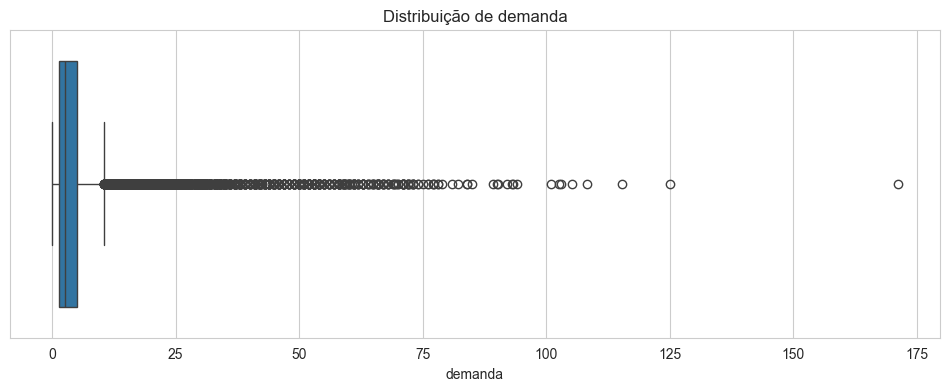

In [ ]:
# Verificando Buracos no Tempo (Gap Analysis)
data_min = df_train[COL_DATA].min()
data_max = df_train[COL_DATA].max()
all_dates = pd.date_range(start=data_min, end=data_max)
datas_presentes = df_train[COL_DATA].unique()
buracos = set(all_dates) - set(datas_presentes)

print(f"Período: de {data_min} até {data_max}")
print(f"Total de dias esperados: {len(all_dates)}")
print(f"Total de dias presentes: {len(datas_presentes)}")

if len(buracos) > 0:
    print(f"Existem {len(buracos)} dias sem NENHUMA venda no dataset inteiro!")
else:
    print("Continuidade temporal OK (sem dias faltando globalmente).")

# Estatísticas do Target 
n_negativos = (df_train[COL_DEMANDA] < 0).sum()
n_zeros = (df_train[COL_DEMANDA] == 0).sum()
pct_zeros = (n_zeros / len(df_train)) * 100

print(f"\nValores Negativos: {n_negativos}")
print(f"Valores Zerados: {n_zeros} ({pct_zeros:.2f}%)")

# Detecção de Outliers Globais 
plt.figure(figsize=(12, 4))
sns.boxplot(x=df_train[COL_DEMANDA])
plt.title(f'Distribuição de {COL_DEMANDA}')
plt.show()

--- DIAGNÓSTICO DE ZEROS E MAGNITUDE (demanda) ---

Visão Geral:
Total de Registros: 27579
Nulos (NaN): 0 (0.0%)
Zeros Exatos (0.0): 0 (0.0%)
Vendas Positivas (>0): 27579 (100.0%)
--------------------------------------------------

Unidade (unidade):
        % Zeros  Contagem   Min  Mediana (Geral)     Max
unidade                                                 
KG         0.0%     26405 0.040            2.534 171.136
UN         0.0%      1174 1.000           12.000 101.000
--------------------------------------------------

Distribuição dos Valores Positivos (Escala Log):


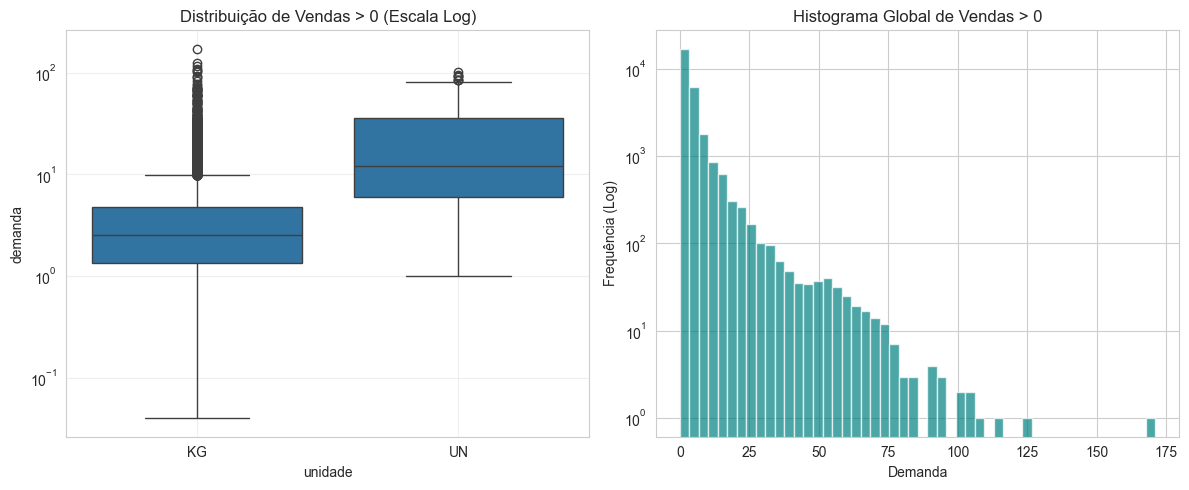

In [4]:
# Configuração de estilo
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def diagnostico_zeros_magnitude(df, col_target, col_unidade):
    print(f"--- DIAGNÓSTICO DE ZEROS E MAGNITUDE ({col_target}) ---")
    
    total_linhas = len(df)
    n_nulos = df[col_target].isna().sum()
    n_zeros = (df[col_target] == 0).sum()
    n_positivos = (df[col_target] > 0).sum()
    
    print(f"\nVisão Geral:")
    print(f"Total de Registros: {total_linhas}")
    print(f"Nulos (NaN): {n_nulos} ({n_nulos/total_linhas:.1%})")
    print(f"Zeros Exatos (0.0): {n_zeros} ({n_zeros/total_linhas:.1%})")
    print(f"Vendas Positivas (>0): {n_positivos} ({n_positivos/total_linhas:.1%})")
    
    print("-" * 50)
    
    print(f"\nUnidade ({col_unidade}):")
    df_temp = df.copy()
    df_temp['is_zero'] = (df_temp[col_target] == 0).astype(int)
    
    resumo = df_temp.groupby(col_unidade).agg({
        'is_zero': 'mean',         
        col_target: ['count', 'min', 'median', 'max'] 
    })
    
    # Renomeando para ficar legível
    resumo.columns = ['% Zeros', 'Contagem', 'Min', 'Mediana (Geral)', 'Max']
    resumo['% Zeros'] = resumo['% Zeros'].apply(lambda x: f"{x:.1%}")
    print(resumo)
    
    print("-" * 50)

    print(f"\nDistribuição dos Valores Positivos (Escala Log):")
    dados_positivos = df[df[col_target] > 0]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=dados_positivos, x=col_unidade, y=col_target)
    plt.yscale('log') 
    plt.title('Distribuição de Vendas > 0 (Escala Log)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(dados_positivos[col_target], bins=50, log=True, color='teal', alpha=0.7)
    plt.title('Histograma Global de Vendas > 0')
    plt.xlabel('Demanda')
    plt.ylabel('Frequência (Log)')
    
    plt.tight_layout()
    plt.show()

diagnostico_zeros_magnitude(df_train, COL_DEMANDA, COL_UNIDADE)

In [5]:
nulls = df_prod.isnull().sum()

print(nulls)

SKU                1
NOME_PRODUTO       1
CATEGORIA       2002
SUBCATEGORIA    2002
dtype: int64


### Análise Temporal - Tendência e Sazonalidade

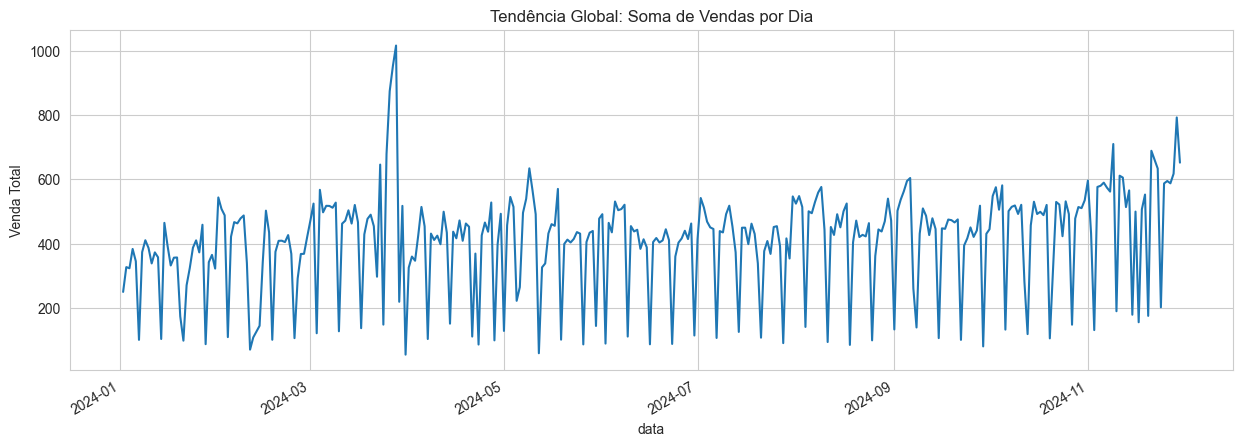

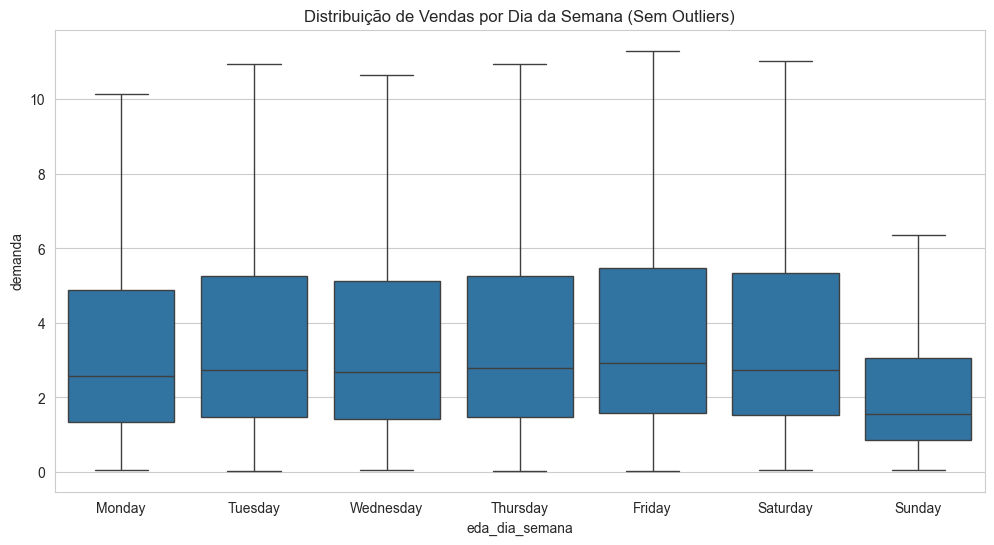

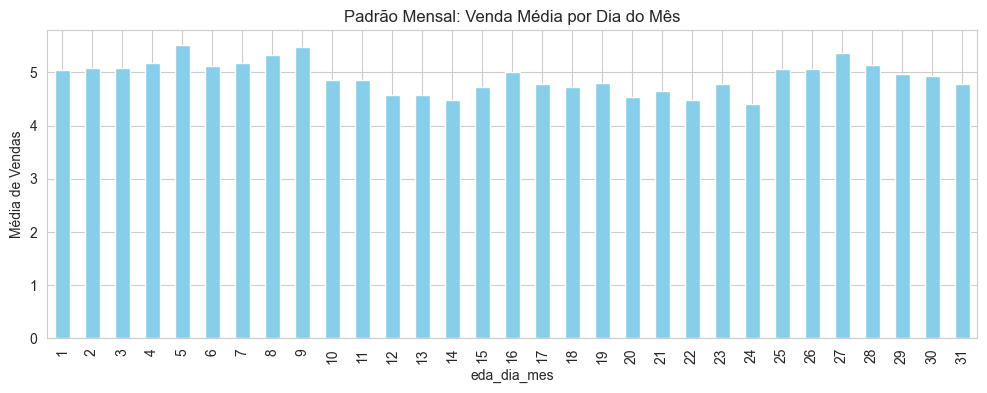

In [6]:
# Features temporais derivadas para os gráficos
df_train['eda_mes'] = df_train[COL_DATA].dt.month
df_train['eda_dia_semana'] = df_train[COL_DATA].dt.day_name()

order_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Tendência Global 
daily_sales = df_train.groupby(COL_DATA)[COL_DEMANDA].sum()
plt.figure(figsize=(15, 5))
daily_sales.plot()

plt.title('Tendência Global: Soma de Vendas por Dia')
plt.ylabel('Venda Total')
plt.show()

# Sazonalidade Semanal 
plt.figure(figsize=(12, 6))
sns.boxplot(x='eda_dia_semana', y=COL_DEMANDA, data=df_train, order=order_week, showfliers=False)
plt.title('Distribuição de Vendas por Dia da Semana (Sem Outliers)')
plt.show()

# Sazonalidade Mensal 
# Agrupando por dia do mês (1-31)
df_train['eda_dia_mes'] = df_train[COL_DATA].dt.day
monthly_pattern = df_train.groupby('eda_dia_mes')[COL_DEMANDA].mean()

plt.figure(figsize=(12, 4))
monthly_pattern.plot(kind='bar', color='skyblue')
plt.title('Padrão Mensal: Venda Média por Dia do Mês')
plt.ylabel('Média de Vendas')
plt.show()

### Análise Granular 

Total de Produtos: 58
Produtos que representam 80% das vendas: 23 (39.7%)


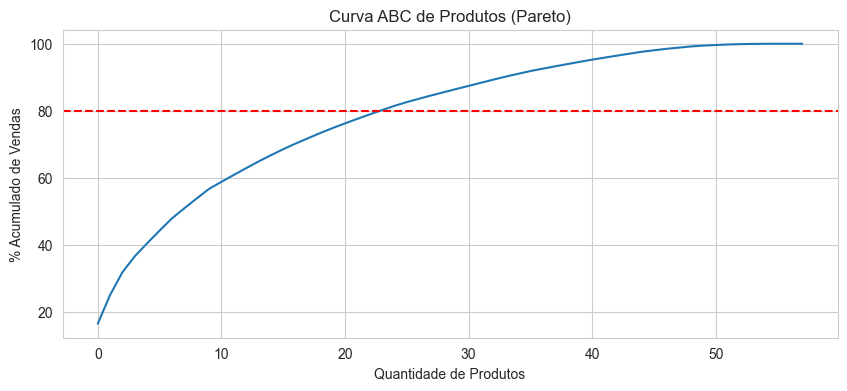

Text(0.5, 1.0, 'Filiais presentes')

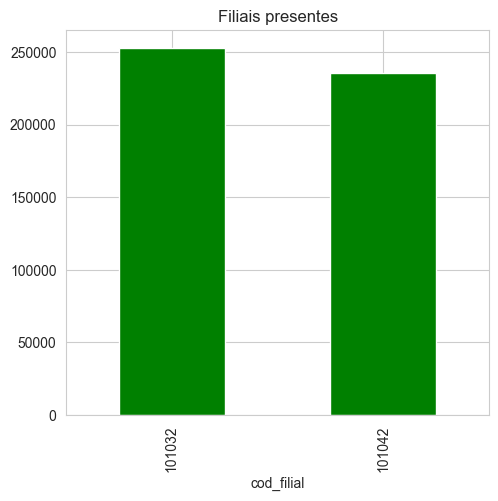

In [ ]:
# Curva ABC de Produtos
prod_sales = df_train.groupby(COL_SKU)[COL_DEMANDA].sum().sort_values(ascending=False)
pareto = prod_sales.cumsum() / prod_sales.sum() * 100

# Identificando corte de 80%
top_products = pareto[pareto <= 80].index.tolist()
print(f"Total de Produtos: {df_train[COL_SKU].nunique()}")
print(f"Produtos que representam 80% das vendas: {len(top_products)} ({len(top_products)/df_train[COL_SKU].nunique():.1%})")

plt.figure(figsize=(10, 4))
plt.plot(range(len(pareto)), pareto.values)
plt.axhline(80, color='red', linestyle='--')
plt.title('Curva ABC de Produtos (Pareto)')
plt.ylabel('% Acumulado de Vendas')
plt.xlabel('Quantidade de Produtos')
plt.show()

# Comparativo de Lojas 
store_sales = df_train.groupby(COL_COD_FILIAL)[COL_NUM_TRANSACOES].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
store_sales.plot(kind='bar', color='green')
plt.title('Filiais presentes')

#### Entendendo, incipientemente, a influência de outros dados categóricos

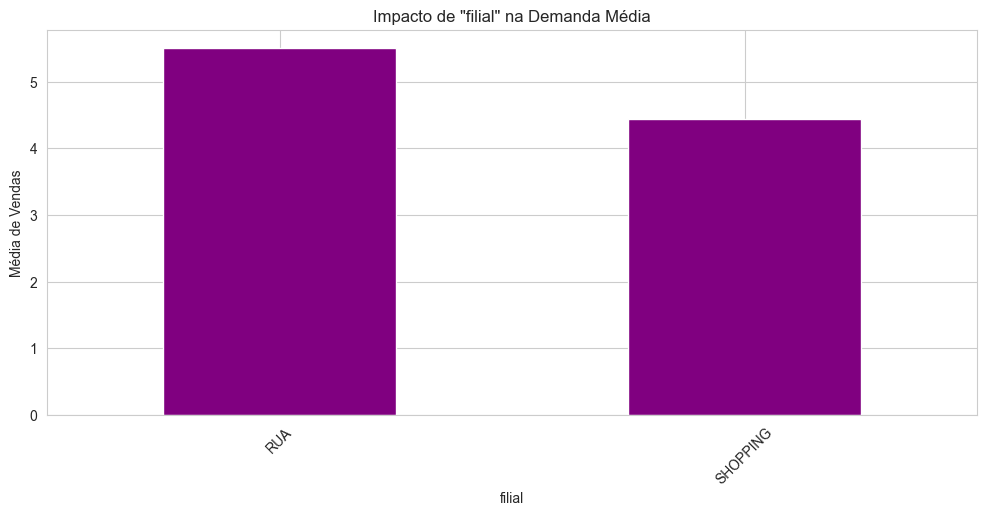

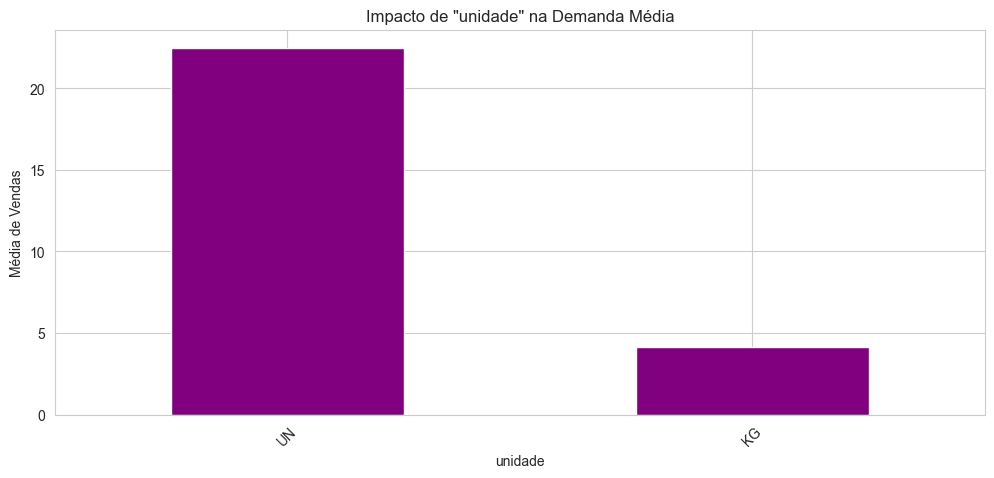

In [8]:
COLS_DEMAIS_METADADOS = ['filial', 'unidade'] 

for col in COLS_DEMAIS_METADADOS:
    if col in df_train.columns:
        plt.figure(figsize=(12, 5))
        
        agg_data = df_train.groupby(col)[COL_DEMANDA].mean().sort_values(ascending=False)
        
        agg_data.plot(kind='bar', color='purple')
        plt.title(f'Impacto de "{col}" na Demanda Média')
        plt.ylabel('Média de Vendas')
        plt.xticks(rotation=45)
        plt.show()
        
    else:
        print(f"Coluna '{col}' não encontrada no DataFrame.")

### Correlação e Autocorrelação

<Figure size 1200x600 with 0 Axes>

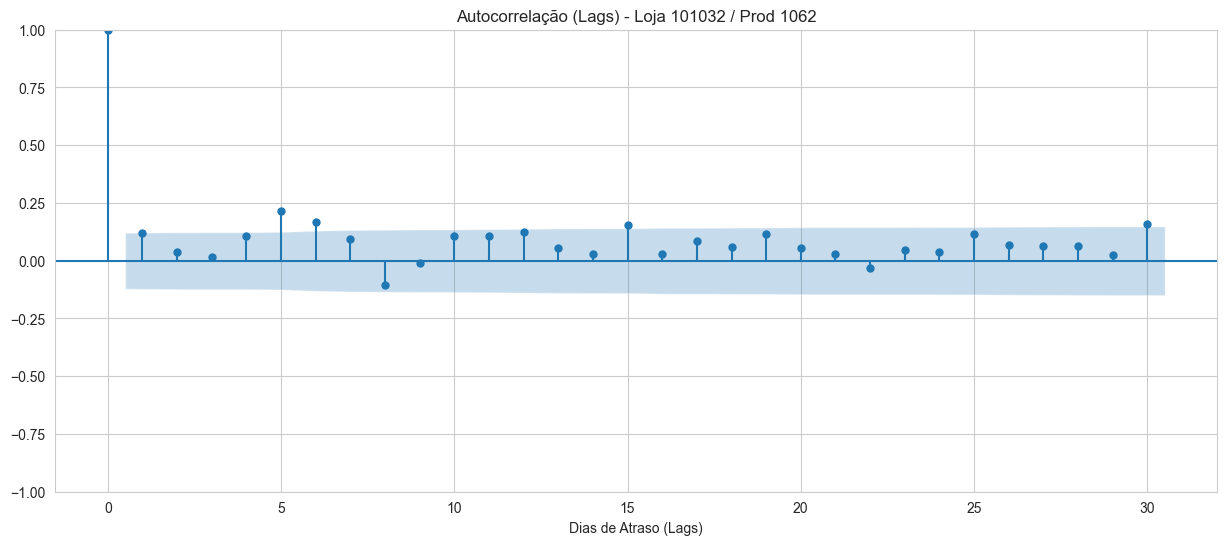

In [9]:
top_loja = store_sales.index[0]
top_prod = prod_sales.index[0]

subset = df_train[(df_train[COL_COD_FILIAL] == top_loja) & (df_train[COL_SKU] == top_prod)].sort_values(COL_DATA)
series_subset = subset.set_index(COL_DATA)[COL_DEMANDA]

if len(series_subset) > 0:
    plt.figure(figsize=(12, 6))
    
    # Plot ACF (Autocorrelation Function)
    plot_acf(series_subset, lags=30, title=f'Autocorrelação (Lags) - Loja {top_loja} / Prod {top_prod}')
    plt.xlabel('Dias de Atraso (Lags)')
    plt.show()
else:
    print("Não foi possível gerar ACF (dados insuficientes para o Top Produto/Loja).")

## Pipeline de Produção

### Limpeza e Tratamento dos Dados


In [10]:
train = pd.read_csv('./data/train.csv', parse_dates=['data'])
test = pd.read_csv('./data/test.csv', parse_dates=['data'])
produto = pd.read_csv('./data/produto.csv')

produto.columns = produto.columns.str.lower()

train = train.merge(produto, on='sku', how='left')
test = test.merge(produto, on='sku', how='left')

print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (27579, 12)
Test Shape: (2753, 9)


### Criação de Features

In [ ]:
def create_features(df):
    df = df.copy()
    # Features básicas de data
    df['semana_ano'] = df['data'].dt.isocalendar().week.astype(int)
    df['dia_semana'] = df['data'].dt.dayofweek
    df['fim_de_semana'] = (df['dia_semana'] >= 5).astype(int)
    df['dia_mes'] = df['data'].dt.day
    
    # 1. Corrida de Natal: 18 a 24 de Dezembro
    df['periodo_natal'] = df['data'].apply(lambda x: 1 if x.month == 12 and 18 <= x.day <= 24 else 0)
    
    # 2. Pós-Natal/Pré-Ano Novo: A partir do dia 26
    df['pos_natal'] = df['data'].apply(lambda x: 1 if x.month == 12 and x.day >= 26 else 0)
    
    # 3. Contagem regressiva (Distância para o dia 25)
    df['contagem_natal'] = df['data'].apply(lambda x: (25 - x.day) if x.month == 12 and x.day <= 25 else 30)
    
    return df

train = create_features(train)
test = create_features(test)

print("Features de calendário criadas.")

# Extraindo tendências recentes
novembro = train[train['data'] >= '2024-11-01']

# Agrupamento
tendencia_nov = novembro.groupby(['sku', 'cod_filial'])['demanda'].agg(['mean', 'std']).reset_index()
tendencia_nov.columns = ['sku', 'cod_filial', 'tendencia_atual', 'alteracoes_atuais']

# Merge de volta no Treino e Teste
train = train.merge(tendencia_nov, on=['sku', 'cod_filial'], how='left')
test = test.merge(tendencia_nov, on=['sku', 'cod_filial'], how='left')

# Preenchimento de Nulos (FIQUEI DIVIDIDO ENTRE UTILIZAR A MÉDIA E A MEDIANA, PARA EVITAR PROBLEMAS COM OUTLIERS OPTEI POR ENVIAR AS DUAS NO KAGGLE E MANTER A MEDIANA AQUI :))
median_global = train['demanda'].median()

train['tendencia_atual'] = train['tendencia_atual'].fillna(median_global)
test['tendencia_atual'] = test['tendencia_atual'].fillna(median_global)

train['alteracoes_atuais'] = train['alteracoes_atuais'].fillna(0)
test['alteracoes_atuais'] = test['alteracoes_atuais'].fillna(0)

print("Features de tendência recente aplicadas.")

# Definição das colunas
features = [
    'sku', 'cod_filial', 'filial', 'unidade', 'categoria', 'subcategoria',
    'dia_semana', 'dia_mes', 'semana_ano', 'fim_de_semana', 'periodo_natal', 
    'pos_natal', 'tendencia_atual', 'alteracoes_atuais', 'contagem_natal'
]

categorical_features = ['filial', 'unidade', 'categoria', 'subcategoria']

# Label Encoding
for col in categorical_features:
    # Convertendo para string para garantir que o Encoder funcione
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    
    le = LabelEncoder()
    le.fit(pd.concat([train[col], test[col]])) # Fit em ambos para garantir todas as classes
    
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

# Criação dos Pesos: Novembro vale o dobro
weights = np.where(train['data'] >= '2024-11-01', 2.0, 1.0)

# Transformação Logarítmica na Target
y_log = np.log1p(train['demanda'])

print("Dados preparados para o modelo.")

Features de calendário criadas.
Features de tendência recente aplicadas.
Dados preparados para o modelo.


### Treinamento

In [12]:
# Dataset do LightGBM
final_train_lgb = lgb.Dataset(train[features], y_log, weight=weights)

# Hiperparâmetros Exatos
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.085,
    'num_leaves': 32,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'force_col_wise': True,
    'verbosity': -1
}

print("Treinando modelo...")
final_model = lgb.train(params, final_train_lgb, num_boost_round=1000)
print("Modelo treinado.")

Treinando modelo...
Modelo treinado.


### Pós-processamento

In [13]:
preds_log = final_model.predict(test[features])

test['demanda'] = np.expm1(preds_log)

top_skus = train.groupby('sku')['demanda'].mean().nlargest(50).index

mask_top_natal = (test['periodo_natal'] == 1) & (test['sku'].isin(top_skus))
test.loc[mask_top_natal, 'demanda'] *= 1.12

mask_normal_natal = (test['periodo_natal'] == 1) & (~test['sku'].isin(top_skus))
test.loc[mask_normal_natal, 'demanda'] *= 1.05

print("Pós-processamento de Natal aplicado.")

Pós-processamento de Natal aplicado.


### Validações e Métricas

Treinando modelo de validação...

Resultados da Validação (Previsão de Novembro):
-----------------------------------------------
RMSE Global: 6.3423
MAE:         2.3862
Bias:        -0.7694


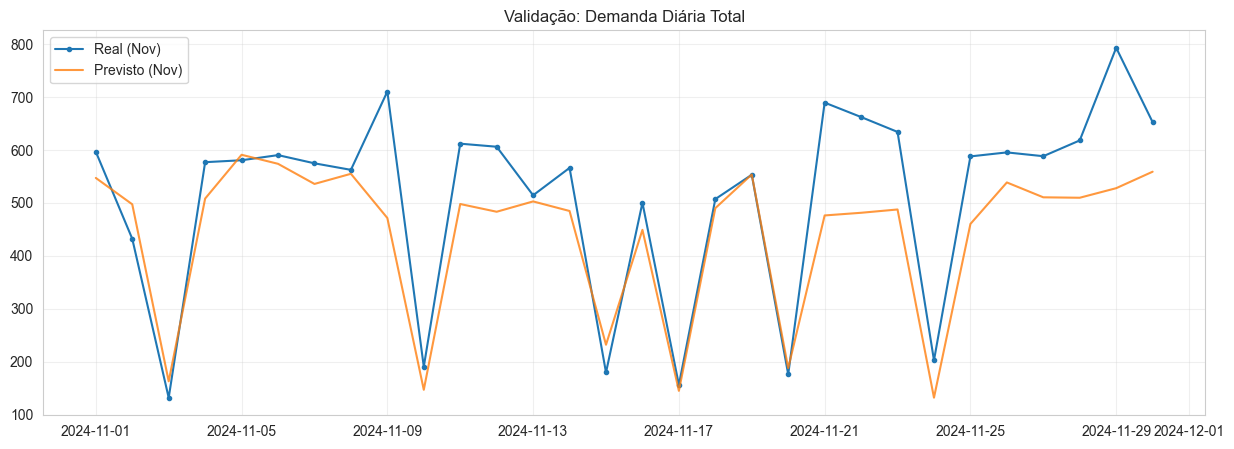

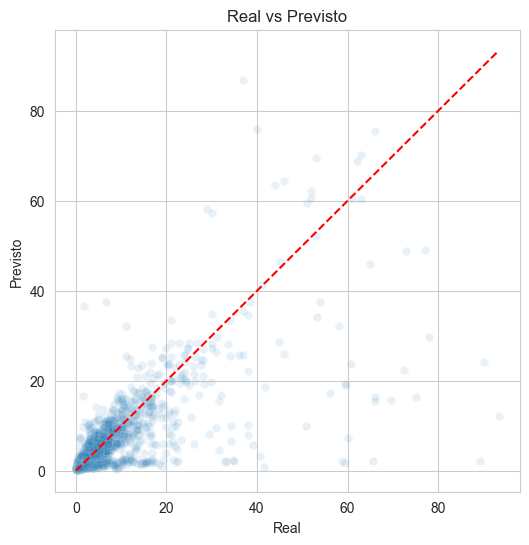

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

mask_val = train['data'] >= '2024-11-01'
train_split = train[~mask_val].copy()
val_split = train[mask_val].copy()

cols_to_drop = ['tendencia_atual', 'alteracoes_atuais']
train_split = train_split.drop(columns=[c for c in cols_to_drop if c in train_split.columns], errors='ignore')
val_split = val_split.drop(columns=[c for c in cols_to_drop if c in val_split.columns], errors='ignore')

outubro = train_split[train_split['data'] >= '2024-10-01']
tendencia_out = outubro.groupby(['sku', 'cod_filial'])['demanda'].agg(['mean', 'std']).reset_index()
tendencia_out.columns = ['sku', 'cod_filial', 'tendencia_atual', 'alteracoes_atuais']

train_split = train_split.merge(tendencia_out, on=['sku', 'cod_filial'], how='left')
val_split = val_split.merge(tendencia_out, on=['sku', 'cod_filial'], how='left')

median_global_val = train_split['demanda'].mean()
train_split['tendencia_atual'] = train_split['tendencia_atual'].fillna(median_global_val)
val_split['tendencia_atual'] = val_split['tendencia_atual'].fillna(median_global_val)
train_split['alteracoes_atuais'] = train_split['alteracoes_atuais'].fillna(0)
val_split['alteracoes_atuais'] = val_split['alteracoes_atuais'].fillna(0)

train_split = create_features(train_split)
val_split = create_features(val_split)

categorical_features = ['filial', 'unidade', 'categoria', 'subcategoria']
for col in categorical_features:
    train_split[col] = train_split[col].astype(str)
    val_split[col] = val_split[col].astype(str)
    
    le = LabelEncoder()
    le.fit(pd.concat([train_split[col], val_split[col]]))
    train_split[col] = le.transform(train_split[col])
    val_split[col] = le.transform(val_split[col])

weights_val = np.where(train_split['data'] >= '2024-10-01', 2.0, 1.0)
y_log_val = np.log1p(train_split['demanda'])

val_train_lgb = lgb.Dataset(train_split[features], y_log_val, weight=weights_val)

print("Treinando modelo de validação...")
model_val = lgb.train(params, val_train_lgb, num_boost_round=1000)

preds_log_val = model_val.predict(val_split[features])
preds_val = np.expm1(preds_log_val)
preds_val = np.clip(preds_val, 0, None)

y_true = val_split['demanda']
rmse = np.sqrt(mean_squared_error(y_true, preds_val))
mae = mean_absolute_error(y_true, preds_val)
bias = np.mean(preds_val - y_true)

print(f"\nResultados da Validação (Previsão de Novembro):")
print(f"-----------------------------------------------")
print(f"RMSE Global: {rmse:.4f}")
print(f"MAE:         {mae:.4f}")
print(f"Bias:        {bias:.4f}")

plt.figure(figsize=(15, 5))

val_split['pred'] = preds_val
daily_true = val_split.groupby('data')['demanda'].sum()
daily_pred = val_split.groupby('data')['pred'].sum()

plt.plot(daily_true.index, daily_true, label='Real (Nov)', marker='.')
plt.plot(daily_pred.index, daily_pred, label='Previsto (Nov)', alpha=0.8)
plt.title("Validação: Demanda Diária Total")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=preds_val, alpha=0.1)
plt.plot([0, y_true.max()], [0, y_true.max()], 'r--')
plt.title("Real vs Previsto")
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.show()

### Submissão

In [15]:
submission = test[['id', 'demanda']].copy()

# Garantias finais
submission['id'] = submission['id'].astype(int)
submission['demanda'] = submission['demanda'].clip(lower=0) 

# Exportar
submission.to_csv('submission.csv', index=False)

print("Arquivo 'submission.csv' gerado com sucesso!")
print(submission.head())

Arquivo 'submission.csv' gerado com sucesso!
   id  demanda
0   0    1.391
1   1    1.142
2   2    1.168
3   3    1.344
4   4    1.244
